In [ ]:
!gdown 1I_cYkJikt6q9Bh6CKgHYc53KJHd9GKdv
!gdown 125bMces4bFkNJ5kdTRmRTPYDnfQA7Mdc
!gdown 17yfGuuIwY_dWIF8Y9c4UunyXYaEfAIIo

Downloading...
From (original): https://drive.google.com/uc?id=1I_cYkJikt6q9Bh6CKgHYc53KJHd9GKdv
From (redirected): https://drive.google.com/uc?id=1I_cYkJikt6q9Bh6CKgHYc53KJHd9GKdv&confirm=t&uuid=ecc2aeb3-6f3c-42ec-a618-46aeb8141fc5
To: /content/FSDKaggle2018.audio_test.zip
100% 523M/523M [00:13<00:00, 38.0MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=125bMces4bFkNJ5kdTRmRTPYDnfQA7Mdc
From (redirected): https://drive.google.com/uc?id=125bMces4bFkNJ5kdTRmRTPYDnfQA7Mdc&confirm=t&uuid=0cac42ad-5045-47ec-9d77-ae077756f032
To: /content/FSDKaggle2018.audio_train.zip
100% 4.06G/4.06G [01:22<00:00, 49.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=17yfGuuIwY_dWIF8Y9c4UunyXYaEfAIIo
To: /content/FSDKaggle2018.meta.zip
100% 129k/129k [00:00<00:00, 82.3MB/s]


In [ ]:
%%capture
!unzip FSDKaggle2018.audio_train.zip
!unzip FSDKaggle2018.audio_test.zip
!unzip FSDKaggle2018.meta.zip

In [ ]:
"Required Imports"
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision import models
from collections import defaultdict
import torchaudio.transforms as T
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchaudio
import pandas as pd
from tqdm import tqdm
import numpy as np
import random
import os
from itertools import compress
import torch.nn.functional as F
from torch.optim.lr_scheduler import CosineAnnealingLR
import wandb

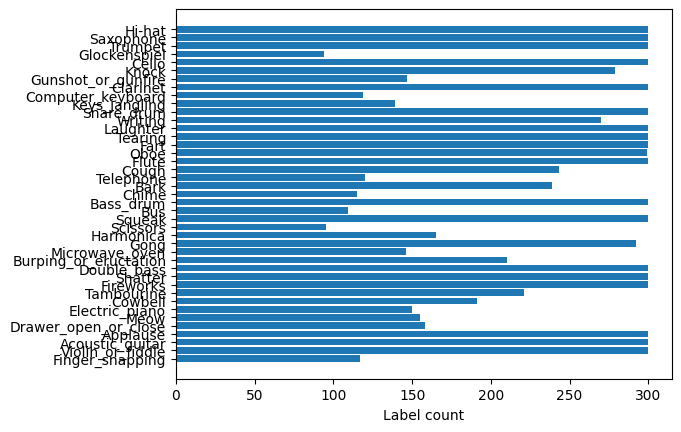

In [ ]:
train_dir = "FSDKaggle2018.audio_train"
test_dir = "FSDKaggle2018.audio_test"

train_df = pd.read_csv("/content/FSDKaggle2018.meta/train_post_competition.csv")
test_df = pd.read_csv("/content/FSDKaggle2018.meta/test_post_competition_scoring_clips.csv")

train_labels = list(train_df["label"].unique())

dict_label_cnt = defaultdict(int)

for index, row in train_df.iterrows():
    dict_label_cnt[row["label"]] += 1

audio_names = list(dict_label_cnt.keys())
audio_counts = list(dict_label_cnt.values())

y_pos = np.arange(len(audio_names))

fig, ax = plt.subplots()
ax.barh(y_pos, audio_counts,  align='center')
ax.set_yticks(y_pos, labels=audio_names)
ax.invert_yaxis()
ax.set_xlabel('Label count')
plt.show()

ID_CLASS_LABEL = train_labels[:20]
OOD_CLASS_LABEL = train_labels[20:]

ltoi = {label: index for index, label in enumerate(ID_CLASS_LABEL)}
itol = {index: label for index, label in enumerate(ID_CLASS_LABEL)}

train_dataset_paths = []
test_dataset_paths = []

for index, row in train_df.iterrows():
    audio_path, label = os.path.join(train_dir, row["fname"]), row["label"]
    train_dataset_paths.append((audio_path, label))

for index, row in test_df.iterrows():
    audio_path, label = os.path.join(test_dir, row["fname"]), row["label"]
    test_dataset_paths.append((audio_path, label))

In [ ]:
id_class_data = defaultdict(list)
ood_data = []

for audio_path, label in train_dataset_paths:
    if label in ID_CLASS_LABEL:
        id_class_data[label].append((audio_path, ltoi[label]))
    else:
        ood_data.append(audio_path)

train_labeled_dataset = []
id_unlabeled_dataset = []

for label, items in id_class_data.items():
    random.shuffle(items)
    half = len(items) // 2
    train_labeled_dataset.extend(items[:half])
    id_unlabeled_dataset.extend([audio_path for audio_path, _ in items[half:]])

combined_unlabeled = id_unlabeled_dataset + ood_data
desired_unlabeled_count = 3 * len(train_labeled_dataset)

if len(combined_unlabeled) > desired_unlabeled_count:
    random.shuffle(combined_unlabeled)
    train_unlabeled_dataset = combined_unlabeled[:desired_unlabeled_count]
else:
    max_labeled = len(combined_unlabeled) // 3
    random.shuffle(train_labeled_dataset)
    train_labeled_dataset = train_labeled_dataset[:max_labeled]
    train_unlabeled_dataset = combined_unlabeled[:3 * max_labeled]

test_labeled_dataset = []
for audio_path, label in test_dataset_paths:
    if label in ID_CLASS_LABEL:
        test_labeled_dataset.append((audio_path, ltoi[label]))
    else:
        test_labeled_dataset.append((audio_path, -1))
ID_CLASSES = [ltoi[l] for l in ID_CLASS_LABEL]

In [ ]:
print(len(train_unlabeled_dataset))
print(len(train_labeled_dataset))
print(len(train_unlabeled_dataset)/len(train_labeled_dataset))
print(len(test_labeled_dataset))

7002
2334
3.0
1600


In [ ]:
import torch
import torchaudio.transforms as T
import torch.nn.functional as F
from torch.utils.data import Dataset

class FSDDataset(Dataset):
    def __init__(self, dataset, is_labeled=True, sample_rate=16000, n_mels=64, target_length=200):
        self.dataset = dataset
        self.is_labeled = is_labeled
        self.sample_rate = sample_rate
        self.target_length = target_length
        self.weak_aug = T.Vol(gain=torch.FloatTensor(1).uniform_(0.9, 1.1).item(), gain_type="amplitude")
        self.strong_aug = torch.nn.Sequential(
            T.Vol(gain=torch.FloatTensor(1).uniform_(0.5, 1.5).item(), gain_type="amplitude"),
            T.FrequencyMasking(freq_mask_param=15),
            T.TimeMasking(time_mask_param=35)
        )

        self.mel_transform = T.MelSpectrogram(
            sample_rate=sample_rate,
            n_fft=1024,
            hop_length=512,
            n_mels=n_mels
        )
        self.db_transform = T.AmplitudeToDB()

    def __len__(self):
        return len(self.dataset)

    def _load_audio(self, path):
        waveform, sr = torchaudio.load(path)
        if sr != self.sample_rate:
            resampler = T.Resample(sr, self.sample_rate)
            waveform = resampler(waveform)
        return waveform

    def _weak_augment(self, x):
        return self.weak_aug(x)

    def _strong_augment(self, x):
        return self.strong_aug(x)

    def _to_log_mel(self, x):
        mel = self.mel_transform(x)
        log_mel = self.db_transform(mel)
        return log_mel

    def _resize_spectrogram(self, x):
        current_length = x.size(2)
        if current_length < self.target_length:
            padding = self.target_length - current_length
            x = F.pad(x, (0, padding))
        elif current_length > self.target_length:
            x = x[:, :, :self.target_length]
        return x

    def __getitem__(self, index):
        if self.is_labeled:
            audio_path, label = self.dataset[index]
            audio = self._load_audio(audio_path)
            audio = self._weak_augment(audio)
            log_mel = self._to_log_mel(audio)
            log_mel = self._resize_spectrogram(log_mel)
            return log_mel, torch.tensor(label)
        else:
            audio_path = self.dataset[index]
            audio = self._load_audio(audio_path)
            weak = self._to_log_mel(self._weak_augment(audio))
            strong = self._to_log_mel(self._strong_augment(audio))
            weak = self._resize_spectrogram(weak)
            strong = self._resize_spectrogram(strong)
            return weak, strong


In [ ]:
batch_size = 32
unlabeled_batch_size = 3*batch_size
test_size = 64

In [ ]:
dataset_train_labeled = FSDDataset(train_labeled_dataset, is_labeled=True)
dataset_train_unlabeled = FSDDataset(train_unlabeled_dataset, is_labeled=False)
dataset_test_unlabeled = FSDDataset(test_labeled_dataset, is_labeled=True)
train_labeled_dataloader = DataLoader(dataset_train_labeled, batch_size=batch_size, shuffle=True, drop_last=True)
train_unlabeled_dataloader = DataLoader(dataset_train_unlabeled, batch_size=unlabeled_batch_size, shuffle=True, drop_last=True)
test_labeled_dataloader = DataLoader(dataset_test_unlabeled, batch_size=test_size, shuffle=False, drop_last=True)

In [ ]:
print(dataset_train_labeled[0][0].shape)
for X, y in train_labeled_dataloader:
    print(X.shape)
    print(y.shape)
    break

torch.Size([1, 64, 200])
torch.Size([32, 1, 64, 200])
torch.Size([32])


In [ ]:
class Classifier(nn.Module):
    def __init__(self, in_f, out_f):
        super().__init__()
        self.classifier = nn.Linear(in_f, out_f)

    def forward(self, x):
        return self.classifier(x)

backbone = models.resnet18(weights="DEFAULT")
backbone.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
nn.init.kaiming_normal_(backbone.conv1.weight, mode='fan_out', nonlinearity='relu')
feature_dim = 128
num_ftrs = backbone.fc.in_features
backbone.fc = nn.Linear(num_ftrs, feature_dim)
classifier = Classifier(feature_dim, len(ID_CLASSES))


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 187MB/s]


In [ ]:
x = torch.randn(32, 1, 64, 200)
z = backbone(x)
y = classifier(z)
print("Backbone output shape:", z.shape)
print("Classifier output shape:", y.shape)

Backbone output shape: torch.Size([32, 128])
Classifier output shape: torch.Size([32, 20])


In [ ]:
def get_batch_mean(Z, y, num_classes, feature_dim, batch_size, device):
    sums = torch.zeros(num_classes, feature_dim, dtype=Z_l.dtype, device=device)
    counts = torch.zeros(num_classes, dtype=torch.float, device=device)
    sums = sums.index_add(0, y_l, Z_l, alpha=1)
    ones = torch.ones(batch_size, dtype=torch.float, device=device)
    counts = counts.index_add(0, y_l, ones)
    counts[counts == 0] = 1.0
    avg_values = sums / counts.unsqueeze(1)
    return avg_values


def subspace_score(Z, batch_means):
    """
    Z: (batch_size, feature_dim)
    batch_means: (num_classes, feature_dim)
    Returns:
        cosine similarity between Z and its projection on the subspace
        spanned by batch_means — shape (batch_size, 1)
    """
    Q, _ = torch.linalg.qr(batch_means.T)
    proj_Z = Z @ Q @ Q.T
    cos_sim = F.cosine_similarity(Z, proj_Z, dim=1).clamp(0, 1)
    return cos_sim.unsqueeze(1)


In [ ]:
"Taken from the code given by the authors... "
def beta_pdf(x, alpha, beta, loc=0.0, scale=1.0):
    x = (x - loc) / scale
    alpha = torch.as_tensor(alpha, dtype=torch.float32, device=x.device)
    beta = torch.as_tensor(beta, dtype=torch.float32, device=x.device)
    scale = torch.as_tensor(scale, dtype=torch.float32, device=x.device)
    def xlogy(a, b):
        return torch.where(a == 0, torch.zeros_like(b), a * torch.log(b + 1e-10))
    def xlog1py(a, y):
        return torch.where(a == 0, torch.zeros_like(y), a * torch.log1p(y + 1e-10))

    log_unnormalized = xlogy(alpha - 1.0, x) + xlog1py(beta - 1.0, -x)
    log_normalization = torch.lgamma(alpha) + torch.lgamma(beta) - torch.lgamma(alpha + beta)
    log_prob = log_unnormalized - log_normalization
    log_prob = torch.where((x >= 0) & (x <= 1), log_prob, torch.tensor(float('-inf'), device=x.device))

    return torch.exp(log_prob) / scale

def update_beta_parameters(w_id, w_ood, s_l, s_u ,alpha_id, beta_id, alpha_ood, beta_ood, l):
    # Detaching from computational graph so that it won't cause some bullshit error
    w_id = w_id.squeeze(1).detach(); w_ood = w_ood.squeeze(1).detach()
    s_l = s_l.squeeze(1).detach(); s_u = s_u.squeeze(1).detach()
    nu_id = torch.sum(s_l) + torch.dot(w_id, s_u)/(s_l.size(0) + torch.sum(w_id))
    sigma2_id = (torch.sum(s_l - nu_id)**2 + torch.dot(w_id, (s_u - nu_id)**2))/(s_l.size(0) + torch.sum(w_id))

    nu_ood = torch.dot(w_ood, s_u)/(torch.sum(w_ood))
    sigma2_ood = torch.dot(w_ood, (s_u - nu_id)**2)/((torch.sum(w_ood)))

    _alpha_id = nu_id*((nu_id*(1-nu_id))/sigma2_id - 1)
    _alpha_ood = nu_ood*((nu_ood*(1-nu_ood))/sigma2_ood - 1)
    _beta_id = (1 - nu_id)*((nu_id*(1-nu_id))/sigma2_id - 1)
    _beta_ood = (1 - nu_ood)*((nu_ood*(1-nu_ood))/sigma2_ood - 1)

    return alpha_id*l + (1 - l)*_alpha_id, beta_id*l + (1 - l)*_beta_id, alpha_ood*l + (1 - l)*_alpha_ood, beta_ood*l + (1 - l)*_beta_ood

def get_p_id(s, alpha_id, beta_id, alpha_ood, beta_ood, pi=1.0):
    """
    Compute the ID probability using Beta PDFs instead of torch.distributions.Beta,
    following the formulation in the paper (with loc/scale support implicitly assumed as 0/1).
    """
    beta_pdf_id = beta_pdf(s, alpha_id, beta_id)
    beta_pdf_ood = beta_pdf(s, alpha_ood, beta_ood)
    numerator = beta_pdf_id * pi
    denominator = numerator + beta_pdf_ood * (1 - pi)
    p_id = numerator / (denominator + 1e-8)
    return p_id


In [ ]:
"this function has been tested"
class SelfSupervisionLoss(nn.Module):
    def __init__(self, in_f, out_f):
        super().__init__()
        self.proj = nn.Linear(in_f, out_f, bias=False)

    def forward(self, x_w, x_s):
        x_s_proj = self.proj(x_s)
        x_w = x_w.detach()
        dot_product = torch.sum(x_s_proj * x_w, dim=1)
        norm_product = torch.norm(x_s_proj, dim=1) * torch.norm(x_w, dim=1)
        cosine_sim = dot_product / (norm_product + 1e-8)
        return -cosine_sim.mean()

"Can't this be negative??"
"Though i did test this.."
class SubspaceLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, m_id, m_ood, s_z):
        m_id, m_ood = m_id.to(dtype=float), m_ood.to(dtype=float)
        return torch.mean((m_ood - m_id) * s_z)

"This function has been tested"

class SemiSupervisedLoss(nn.Module):
    def __init__(self, threshold):
        super().__init__()
        self.threshold = threshold

    def forward(self,y_pred, y_true, mask_id):
        """
        logits of model on weakly augmented data: y_true
        logits of model on strongly augmented data: y_pred
        boolean tensors for ID/OOD classification: mask_id
        """
        y_true = y_true.detach()
        batch_size = y_pred.size(0)
        entropy = F.cross_entropy(y_pred, torch.argmax(y_true, dim=1), reduction="none") # input logits, and true labels
        y_prob_true = F.softmax(y_true, dim=1)
        sample_id = torch.logical_and(torch.max(y_prob_true, dim=1)[0] >= self.threshold, (mask_id == 1))
        return (torch.sum(entropy[sample_id]))/batch_size

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
num_epoch = 10
alpha_id, beta_id = torch.tensor(10, device=device),torch.tensor(2, device=device)
alpha_ood, beta_ood = torch.tensor(2, device=device), torch.tensor(10, device=device)
warm_up = 0
lr = 3e-3
backbone.to(device)
classifier.to(device)
supervised_loss_fn = nn.CrossEntropyLoss()
selfsupervised_loss_fn = SelfSupervisionLoss(feature_dim, feature_dim).to(device)
subspace_loss_fn = SubspaceLoss().to(device)
semisupervised_loss_fn = SemiSupervisedLoss(0.9).to(device)
all_params = list(backbone.parameters()) + list(classifier.parameters()) + list(selfsupervised_loss_fn.parameters())
optimizer = torch.optim.SGD(all_params, lr=0.01, momentum=0.9, nesterov=True)
class_means = torch.zeros((len(ID_CLASSES), feature_dim), requires_grad=False, device=device)
class_mean_EMA = 0.2
test_accuracy, test_classification_report, test_confusion_matrix, test_auc_roc_score = [], [], [], []
num_batches = len(train_labeled_dataloader)
batch_means = torch.zeros(len(ID_CLASSES), feature_dim, device=device)
scheduler = CosineAnnealingLR(optimizer, T_max=100)

In [ ]:
wandb.init(
    project="FSD_KAGGLE_2018",
    name=f"run_{wandb.util.generate_id()}",
    config={
        "epochs": num_epoch,
        "learning_rate": lr,
        "warmup_epochs": warm_up,
        "scheduler": "CosineAnnealingLR",
        "optimizer": "SGD w/ Nesterov",
        "alpha_id": alpha_id.item(),
        "beta_id": beta_id.item(),
        "alpha_ood": alpha_ood.item(),
        "beta_ood": beta_ood.item()
    }
)

In [ ]:
for epoch in range(num_epoch):
    backbone.train();classifier.train();selfsupervised_loss_fn.train()
    for (X_l, y_l), (X_w, X_s) in tqdm(zip(train_labeled_dataloader, train_unlabeled_dataloader), total=num_batches, desc="Training:"):
        "========================Loading inputs to device========================"
        X_l = X_l.to(device)
        y_l = y_l.to(device)
        X_w = X_w.to(device)
        X_s = X_s.to(device)
        "========================Inputs loaded========================"

        "======================= Processing the labeled dataset ======================="
        Z_l = backbone(X_l)
        "=====================Calculating labeled subspace score============================"
        y_pred_l = classifier(Z_l)
        s_l = subspace_score(Z_l, batch_means.detach())
        "=====================Label subspace score calculated============================"
        "============================Label data processed ============================ "

        "======================= Processing the labeled dataset ======================="
        Z_s_u, Z_w_u = backbone(X_w), backbone(X_s)

        " ======================= Calculating subspace score and mask ======================="
        s_u = subspace_score(Z_w_u, batch_means.detach())
        Z_s_u_for_cls = Z_s_u
        Z_w_u_for_cls = Z_w_u

        y_pred_u = classifier(Z_s_u_for_cls)
        y_gold_u = classifier(Z_w_u_for_cls)
        prob_id_u = get_p_id(s_u, alpha_id, beta_id, alpha_ood, beta_ood) # size should be (Un_labeled_batch_size)
        prob_ood_u = 1 - prob_id_u
        uniform = torch.rand(unlabeled_batch_size, device=device)
        mask_id = (prob_id_u.squeeze(1) >= uniform)
        # I hope this works
        mask_ood = torch.logical_not(mask_id)
        " ======================= Calculated subspace score and mask ======================="

        " ============================Calculating losses ============================"
        loss_selfsupervised = selfsupervised_loss_fn(Z_w_u, Z_s_u)
        loss_semi_supervised = semisupervised_loss_fn(y_pred_u, y_gold_u, mask_id.detach())
        loss_subspace = subspace_loss_fn(mask_id, mask_ood, s_u)
        loss_supervised = supervised_loss_fn(y_pred_l, y_l)
        " ============================Losses Calculated ============================"

        " ============================ Optimizing the model ============================"
        if epoch < warm_up:
            loss = 40*loss_selfsupervised + loss_supervised
        else:
            loss = 40*loss_selfsupervised + loss_semi_supervised + loss_subspace + loss_supervised
        loss.backward()
        optimizer.zero_grad()
        optimizer.step()
        " ============================ Model optimized ============================"

        " ======================== Performing IIM Step ======================== "
        alpha_id, alpha_ood, alpha_ood, beta_ood = update_beta_parameters(prob_id_u,prob_ood_u, s_l, s_u ,alpha_id, beta_id, alpha_ood, beta_ood, 0.2)
        " ======================== IIM step done ======================== "
        "======================= Updating class means ======================="
        batch_means = get_batch_mean(Z_l, y_l, len(ID_CLASSES), feature_dim, batch_size, device)
        class_means = class_means*class_mean_EMA + (1 - class_mean_EMA)*batch_means
        "======================= Class means updataed ======================="
        wandb.log({
            "epoch": epoch,
            "loss_supervised": loss_supervised.item(),
            "loss_selfsupervised": loss_selfsupervised.item(),
            "loss_semi_supervised": loss_semi_supervised.item() if epoch >= warm_up else 0.0,
            "loss_subspace": loss_subspace.item() if epoch >= warm_up else 0.0,
        })

    scheduler.step()
    backbone.eval();classifier.eval();selfsupervised_loss_fn.eval()
    test_predictions,test_targets = [], []
    with torch.inference_mode():
        for X, y_true in test_labeled_dataloader:
            y_true = y_true.to(device)
            X = X.to(device)
            Z = backbone(X)
            y_logits = classifier(Z)
            prob_id = get_p_id(Z, alpha_id, beta_id, alpha_ood, beta_ood)
            y_softmax = F.softmax(y_logits, dim=1)
            y_pred = torch.argmax(y_softmax, dim=1, keepdim=False)
            uniform = torch.rand(size=(test_size, ), device=device)
            y_pred[(torch.max(y_softmax, dim=1)[0] < uniform)] = -1
            test_predictions.extend(y_true.cpu().detach().numpy())
            test_targets.extend(y_pred.cpu().detach().numpy())

    acc = accuracy_score(test_predictions, test_targets)
    print(f"epoch = {epoch+1}, acc = {acc:.4f}")
    test_accuracy.append(acc)
    test_classification_report.append(classification_report(test_predictions, test_targets, zero_division=0))
    test_confusion_matrix.append(confusion_matrix(test_predictions, test_targets))
    torch.save(backbone.state_dict(), f"backbone_epoch_{epoch}.pth")
    torch.save(classifier.state_dict(), f"classifier_epoch_{epoch}.pth")
    torch.save(selfsupervised_loss_fn.state_dict(), f"selfsupervised_loss_fn_epoch_{epoch}.pth")

wandb.finish()

Training:: 100%|██████████| 72/72 [04:11<00:00,  3.50s/it]


epoch = 1, acc = 0.4244


Training:: 100%|██████████| 72/72 [04:11<00:00,  3.50s/it]


epoch = 2, acc = 0.4175


Training:: 100%|██████████| 72/72 [04:09<00:00,  3.46s/it]


epoch = 3, acc = 0.4181


Training::  31%|███       | 22/72 [01:19<03:01,  3.63s/it]


KeyboardInterrupt: 

In [ ]:
beta_parameters = torch.stack([alpha_id, beta_id, alpha_ood, beta_ood])
torch.save(beta_parameters, "beta_parameters.pth")
torch.save(batch_means, "batch_means.pth")

NameError: name 'torch' is not defined

In [ ]:
"Required Imports"
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision import models
from collections import defaultdict
import torchaudio.transforms as T
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchaudio
import pandas as pd
from tqdm import tqdm
import numpy as np
import random
import os
from itertools import compress
import torch.nn.functional as F
import wandb
import torch.nn.functional as F

In [ ]:
"Taken from the code given by the authors... "
def beta_pdf(x, alpha, beta, loc=0.0, scale=1.0):
    x = (x - loc) / scale
    device = x.device
    alpha = torch.as_tensor(alpha, dtype=torch.float32, device=device)
    beta = torch.as_tensor(beta, dtype=torch.float32, device=device)
    scale = torch.as_tensor(scale, dtype=torch.float32, device=device)

    def xlogy(a, b):
        return torch.where(a == 0, torch.zeros_like(b), a * torch.log(b + 1e-10))

    def xlog1py(a, y):
        return torch.where(a == 0, torch.zeros_like(y), a * torch.log1p(y + 1e-10))

    log_unnormalized = xlogy(alpha - 1.0, x) + xlog1py(beta - 1.0, -x)
    log_normalization = torch.lgamma(alpha) + torch.lgamma(beta) - torch.lgamma(alpha + beta)
    log_prob = log_unnormalized - log_normalization
    log_prob = torch.where((x >= 0) & (x <= 1), log_prob, torch.tensor(float('-inf'), device=device))

    return torch.exp(log_prob) / scale

def subspace_score(Z, batch_means):
    """
    Z: (batch_size, feature_dim)
    batch_means: (num_classes, feature_dim)
    Returns:
        cosine similarity between Z and its projection on the subspace
        spanned by batch_means — shape (batch_size, 1)
    """
    Q, _ = torch.linalg.qr(batch_means.T)
    proj_Z = Z @ Q @ Q.T
    cos_sim = F.cosine_similarity(Z, proj_Z, dim=1).clamp(0, 1)
    return cos_sim.unsqueeze(1)

class Classifier(nn.Module):
    def __init__(self, in_f, out_f):
        super().__init__()
        self.classifier = nn.Linear(in_f, out_f)

    def forward(self, x):
        return self.classifier(x)
    "Taken from the code given by the authors... "
def beta_pdf(x, alpha, beta, loc=0.0, scale=1.0):
    x = (x - loc) / scale
    alpha = torch.as_tensor(alpha, dtype=torch.float32, device=x.device)
    beta = torch.as_tensor(beta, dtype=torch.float32, device=x.device)
    scale = torch.as_tensor(scale, dtype=torch.float32, device=x.device)
    def xlogy(a, b):
        return torch.where(a == 0, torch.zeros_like(b), a * torch.log(b + 1e-10))
    def xlog1py(a, y):
        return torch.where(a == 0, torch.zeros_like(y), a * torch.log1p(y + 1e-10))

    log_unnormalized = xlogy(alpha - 1.0, x) + xlog1py(beta - 1.0, -x)
    log_normalization = torch.lgamma(alpha) + torch.lgamma(beta) - torch.lgamma(alpha + beta)
    log_prob = log_unnormalized - log_normalization
    log_prob = torch.where((x >= 0) & (x <= 1), log_prob, torch.tensor(float('-inf'), device=x.device))

    return torch.exp(log_prob) / scale

def get_p_id(s, alpha_id, beta_id, alpha_ood, beta_ood, pi=1.0):
    """
    Compute the ID probability using Beta PDFs instead of torch.distributions.Beta,
    following the formulation in the paper (with loc/scale support implicitly assumed as 0/1).
    """
    beta_pdf_id = beta_pdf(s, alpha_id, beta_id)
    beta_pdf_ood = beta_pdf(s, alpha_ood, beta_ood)
    numerator = beta_pdf_id * pi
    denominator = numerator + beta_pdf_ood * (1 - pi)
    p_id = numerator / (denominator + 1e-8)
    return p_id

class InferenceModelAudio:
    def __init__(self, backbone_pth, classifier_pth, batch_mean_pth, beta_parameters_pth):
        self.feature_dim = 128
        self.num_classes = 20
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.backbone = models.resnet18(weights=None)
        self.backbone.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        nn.init.kaiming_normal_(self.backbone.conv1.weight, mode='fan_out', nonlinearity='relu')
        self.num_ftrs = self.backbone.fc.in_features
        self.backbone.fc = nn.Linear(self.num_ftrs, self.feature_dim)
        self.backbone.load_state_dict(torch.load(backbone_pth, map_location=self.device))
        self.backbone = self.backbone.to(self.device)
        self.backbone.eval()

        self.classifier = Classifier(self.feature_dim, self.num_classes)
        self.classifier.load_state_dict(torch.load(classifier_pth, map_location=self.device))
        self.classifier = self.classifier.to(self.device)
        self.classifier.eval()

        self.batch_means = torch.load(batch_mean_pth, map_location=self.device).to(self.device)
        beta_parameters = torch.load(beta_parameters_pth, map_location=self.device).to(self.device)
        self.alpha_id, self.beta_id, self.alpha_ood, self.beta_ood = beta_parameters.chunk(4)

        self.weak_aug = T.Vol(gain=torch.FloatTensor(1).uniform_(0.9, 1.1).item(), gain_type="amplitude")
        self.sample_rate = 16000
        self.target_length = 200
        self.mel_transform = T.MelSpectrogram(
            sample_rate=self.sample_rate,
            n_fft=1024,
            hop_length=512,
            n_mels=64
        ).to(self.device)
        self.db_transform = T.AmplitudeToDB().to(self.device)

    def _load_audio(self, path):
        waveform, sr = torchaudio.load(path)
        if sr != self.sample_rate:
            resampler = T.Resample(sr, self.sample_rate).to(self.device)
            waveform = resampler(waveform.to(self.device))
        else:
            waveform = waveform.to(self.device)
        return waveform

    def _to_log_mel(self, x):
        mel = self.mel_transform(x)
        log_mel = self.db_transform(mel)
        return log_mel

    def _resize_spectrogram(self, x):
        current_length = x.size(2)
        if current_length < self.target_length:
            padding = self.target_length - current_length
            x = F.pad(x, (0, padding))
        elif current_length > self.target_length:
            x = x[:, :, :self.target_length]
        return x

    def get_spectogram(self, audio_path):
        audio = self._load_audio(audio_path)
        log_mel = self._to_log_mel(audio)
        log_mel = self._resize_spectrogram(log_mel)
        return log_mel


    def __call__(self, audio_wav):
        device = "cuda" if torch.cuda.is_available() else "cpu"
        spectogram = self.get_spectogram(audio_wav).unsqueeze(0)
        spectogram = spectogram.to(self.device)
        Z = self.backbone(spectogram)
        s_score = subspace_score(Z, self.batch_means)
        p_id = get_p_id(s_score, self.alpha_id, self.beta_id, self.alpha_ood, self.beta_ood)
        uniform = torch.rand(1).to(device)
        if(p_id[0] < uniform[0]):
            return -1
        y = self.classifier(Z)
        return torch.argmax(y, dim=1)



In [ ]:
backbone_pth = "backbone_fsd_kaggle.pth"
classifier_pth = "classifier_epoch_fsd_kaggle.pth"
beta_parameters_pth = "beta_parameters_fsd_kaggle.pth"
batch_mean_pth = "batch_means_fsd_kaggle.pth"

test_inf = InferenceModelAudio(backbone_pth, classifier_pth, batch_mean_pth, beta_parameters_pth)
print(test_inf("/content/00044347.wav"))

tensor([11])
